In [102]:
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import explode, udf, size, col, concat_ws, to_date, to_timestamp, date_trunc, count, array_contains, month, dayofmonth, hour, explode_outer, split
import plotly.express as px
import plotly.graph_objects as go
import pandas
import pandasql
import numpy as np

spark = SparkSession.builder.appName('practice').config('spark.jars.packages', 'mysql:mysql-connector-java:8.0.30').master(
    "local").getOrCreate()

hourly_df = spark.read.format("jdbc").option("url", "jdbc:mysql://localhost:3306/cs179g") \
    .option("driver", "com.mysql.jdbc.Driver").option("dbtable", "stocks_hourly") \
    .option("user", "Garrett").option("password", "123").load()

monthly_df = spark.read.format("jdbc").option("url", "jdbc:mysql://localhost:3306/cs179g") \
    .option("driver", "com.mysql.jdbc.Driver").option("dbtable", "stocks_monthly") \
    .option("user", "Garrett").option("password", "123").load()

top_tags = spark.read.format("jdbc").option("url", "jdbc:mysql://localhost:3306/cs179g") \
    .option("driver", "com.mysql.jdbc.Driver").option("dbtable", "top_tags") \
    .option("user", "Garrett").option("password", "123").load()

In [ ]:
#User Input
stock_day = 26
stock_month = 10
stock_ticker = 'TEAM'

In [ ]:
hourly_df.createOrReplaceTempView("current_stock")
monthly_df.createOrReplaceTempView("monthly")
top_tags.createOrReplaceTempView("top_tags")

current_stock = spark.sql(f"SELECT * from current_stock where day = {stock_day} and month = {stock_month} and ticker = '{stock_ticker}' order by hour")
current_stock = current_stock.toPandas()

In [107]:
#some issue with our DB
hourly_tags = spark.sql(f"Select tags, times, hour from top_tags where tickers = '{stock_ticker}' and month = {stock_month} and day = {stock_day} group by tickers, times,tags, hour order by times DESC  ")
hourly_tags.createOrReplaceTempView("tags_hour")
tags_freq=[]

In [108]:
a=hourly_tags.toPandas()

In [116]:
pandasql.sqldf(f"SELECT tags, times from a where hour = {8} order by times DESC limit 3",locals()).head(10)

,tags,times
0,DEFI,329
1,STABLEFUND,256
2,SAFUU,256


In [99]:
spark.sql(f"SELECT tags, times from tags_hour where hour = {i[0]} order by times DESC limit 3").toPandas().head(10)

,tags,times
0,ETHERNITYCLOUD,27
1,WEB3,27
2,ETNYSUPPORTER,18


In [ ]:
text=[]
for i in np.array(current_stock['hour']).reshape(-1,1):
    tmp = spark.sql(f"SELECT tags, times from tags_hour where hour = {i[0]} order by times DESC limit 3").toPandas()
    text_hour = ""
    for j, row in tmp.iterrows():
        text=""
        for col in tmp.columns.values:
            if(col == 'tags'):
                text += f"#{row[col]}: "
            else:
                text += f"{row[col]}, "
        print(i,text)
        text_hour+=text
    tags_freq.append(i)
    tags_freq.append([text_hour])

[8] #DEFI: 329, 
[8] #STABLEFUND: 256, 
[8] #GRAPE: 256, 
[9] #DRIP: 153, 
[9] #GRAPE: 153, 
[9] #SAFUU: 153, 
[10] #JOINTAKEDA: 140, 
[10] #SAFUU: 140, 
[10] #BATTLESTAKES: 140, 
[11] #DEFI: 188, 
[11] #DRIP: 167, 
[11] #GRAPE: 167, 
[12] #DEFI: 50, 
[12] #GRAPE: 38, 
[12] #EMP: 38, 
[13] #DEFI: 81, 
[13] #DRIP: 51, 
[13] #STABLEFUND: 51, 
[14] #WEB3: 30, 
[14] #ETHERNITYCLOUD: 30, 
[14] #CARACAS: 19, 
[15] #ETHERNITYCLOUD: 27, 
[15] #WEB3: 27, 
[15] #ETNYSUPPORTER: 18, 


In [ ]:
print(tags_freq)

[array([5], dtype=int32), [''], array([6], dtype=int32), [''], array([7], dtype=int32), [''], array([8], dtype=int32), ['#DEFI: 329, #STABLEFUND: 256, #GRAPE: 256, '], array([9], dtype=int32), ['#DRIP: 153, #GRAPE: 153, #SAFUU: 153, '], array([10], dtype=int32), ['#JOINTAKEDA: 140, #SAFUU: 140, #BATTLESTAKES: 140, '], array([11], dtype=int32), ['#DEFI: 188, #DRIP: 167, #GRAPE: 167, '], array([12], dtype=int32), ['#DEFI: 50, #GRAPE: 38, #EMP: 38, '], array([13], dtype=int32), ['#DEFI: 81, #DRIP: 51, #STABLEFUND: 51, '], array([14], dtype=int32), ['#WEB3: 30, #ETHERNITYCLOUD: 30, #CARACAS: 19, '], array([15], dtype=int32), ['#ETHERNITYCLOUD: 27, #WEB3: 27, #ETNYSUPPORTER: 18, ']]


In [ ]:
tags_freq = np.array(tags_freq).reshape(-1,)

In [ ]:
tags_hour = pandas.Series(tags_freq[::2],name ='hour')

In [ ]:
tags_count = pandas.Series(tags_freq[1::2],name = 'times')

In [ ]:
tmp_frame = pandas.DataFrame(columns = ['hour', 'times'])
tmp_frame['hour'] = tags_hour.astype(int)
tmp_frame['times'] = tags_count

In [ ]:
current_stock=current_stock.merge(tmp_frame)

In [ ]:
current_stock.head(15)

,close,high,low,open,ticker,hour,volume,month,day,times
0,197.000,197.0700,197.000,197.070,TEAM,5,1192.0,10,26,
1,202.745,204.3000,194.660,197.000,TEAM,6,143064.0,10,26,
2,205.730,207.9400,203.000,203.170,TEAM,7,191215.0,10,26,
3,205.920,209.1900,205.760,205.820,TEAM,8,168424.0,10,26,"#DEFI: 329, #STABLEFUND: 256, #GRAPE: 256,"
4,200.930,206.7700,200.870,205.865,TEAM,9,120220.0,10,26,"#DRIP: 153, #GRAPE: 153, #SAFUU: 153,"
5,199.460,200.8600,197.190,200.640,TEAM,10,145734.0,10,26,"#JOINTAKEDA: 140, #SAFUU: 140, #BATTLESTAKES: ..."
6,197.420,199.6700,197.065,199.370,TEAM,11,152477.0,10,26,"#DEFI: 188, #DRIP: 167, #GRAPE: 167,"
7,195.230,197.4150,194.620,197.415,TEAM,12,511097.0,10,26,"#DEFI: 50, #GRAPE: 38, #EMP: 38,"
8,201.500,203.8466,195.220,195.220,TEAM,13,23117.0,10,26,"#DEFI: 81, #DRIP: 51, #STABLEFUND: 51,"
9,202.000,202.0000,201.490,201.490,TEAM,14,400.0,10,26,"#WEB3: 30, #ETHERNITYCLOUD: 30, #CARACAS: 19,"


In [121]:
print(spark.sql(f"SELECT close from monthly where day = {stock_day} and month = {stock_month} and ticker = '{stock_ticker}' ").toPandas()['close'])

0    195.22
Name: close, dtype: float64


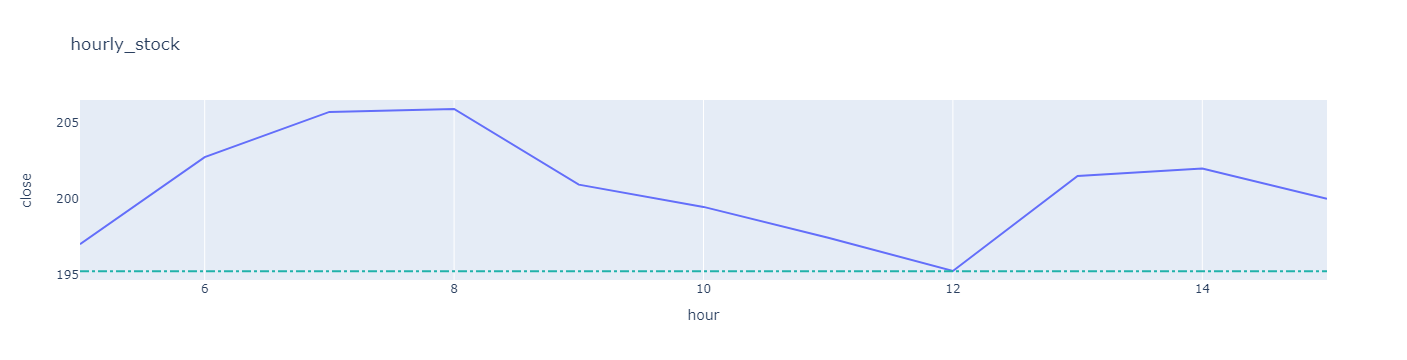

In [ ]:
daily_close = spark.sql(f"SELECT close from monthly where day = {stock_day} and month = {stock_month} and ticker = '{stock_ticker}' ").first()['close']

customdata  = np.stack((current_stock['open'], current_stock['high'], current_stock['low'], current_stock['volume'], current_stock['times']), axis=-1)
fig = px.line(data_frame=current_stock,x='hour', y='close',title='hourly_stock',template='plotly')
fig.update_layout(shapes=[
    # adds line at y=5
    dict(
      type= 'line',
      xref= 'paper', x0=0, x1=1,
      yref= 'y', y0= daily_close, y1= daily_close,
      line=dict(
        color="LightSeaGreen",
        width=2,
        dash="dashdot",
    )
    )
])

fig.update_traces(customdata = customdata, hovertemplate=
                                                                                'open: </b>%{customdata[0]: .2f} <br>' + \
                                                                                'high: </b>%{customdata[1]: .2f} <br>' + \
                                                                                'low: </b>%{customdata[2]: .2f} <br>' + \
                                                                                'volume: </b>%{customdata[3]: ,} <br>'+ \
                                                                                 f"<extra> {stock_ticker} </extra>"+ \
                                                                                 '<extra> %{customdata[4]} </extra>' 
                  
                 )
fig.update_layout(yaxis=dict(showgrid=False))

fig.show()